In [3]:
!pip install torchvision


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [1]:
!pip install -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 5.5 MB/s eta 0:00:00


#import libraries

In [2]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt


#get data set

In [3]:
train_dir="/content/drive/MyDrive/custom-flowers-dataset/train"
val_dir="/content/drive/MyDrive/custom-flowers-dataset/valid"

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#load dataset

In [21]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
train_ds=datasets.ImageFolder(train_dir,transform=transform)
val_ds=datasets.ImageFolder(val_dir,transform=transform)
print(len(train_ds))
print(len(val_ds))

390
45


In [23]:
BATCH_SIZE=16

In [24]:
train_data=DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
val_data=DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=False)

#load model

1.   Load Vit model weights
2.   create an instance of it
3.   freeze the model params
4.   Change the head of vit(reason: the in and out features of actual model is different so changfe it to as required)



In [ ]:
from torch import nn

pre_trainedWeights=torchvision.models.ViT_B_16_Weights.DEFAULT

pt_vit=torchvision.models.vit_b_16(pre_trainedWeights).to(device='cuda')

for parameters in pt_vit.parameters():
  parameters.requires_grad=False

class_names=train_ds.classes
# in_features are 3*16*16=728 input features and out put featuers are 3 classes
pt_vit.heads=nn.Linear(in_features=768,out_features=len(class_names)).to(device)
pt_vit


In [12]:
!pip install torchinfo

#Summary of model

In [16]:
from torchinfo import summary
summary(model=pt_vit,
        input_size=(16,3,224,224), #(bstchsize,channel,l,w)
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names']
      )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [16, 3, 224, 224]    [16, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [16, 3, 224, 224]    [16, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [16, 197, 768]       [16, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [16, 197, 768]       [16, 197, 768]       --                   --
│    └─Sequential (layers)                                   [16, 197, 768]       [16, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [16, 197, 768]       [16, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [16, 197, 768]       [16, 

also it is important to convert the dataset of pretrained model to same as the dataset the model it is trained on.

In [17]:
pt_vit_transforms=pre_trainedWeights.transforms()
print(pt_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [19]:
model=pt_vit

#Train the model

In [26]:
optimizer=torch.optim.Adam(params=model.parameters(),
                           lr=3e-3)
loss_fn=torch.nn.CrossEntropyLoss()

num_epochs=2

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0

    # Training
    model.train()
    for inputs, labels in train_data:
        print("train block")
        inputs=inputs.to(device)
        labels=labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_data:
            print("test block")
            inputs=inputs.to(device)
            labels=labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(train_ds)
    val_loss = val_loss / len(val_ds)
    val_accuracy = val_correct / val_total

    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
torch.save(model.state_dict(), 'vit_model2.pth')

train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
test block
test block
test block
Epoch: 1, Train Loss: 0.3363, Val Loss: 0.0289, Val Accuracy: 1.0000
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
train block
test block
test block
test block
Epoch: 2, Train Loss: 0.0372, Val Loss: 0.0299, Val Accuracy: 0.9778


#Model evaluation reports

In [28]:


from sklearn.metrics import confusion_matrix,classification_report

# Get the predictions for the validation data
model.eval()
with torch.no_grad():
  predictions = []
  true_labels = []
  for inputs, labels in val_data:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    predictions.extend(predicted.tolist())
    true_labels.extend(labels.tolist())

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
cr=classification_report(true_labels,predictions)
# Print the confusion matrix
print(cm)
print(cr)


[[28  1  0]
 [ 0  5  0]
 [ 0  0 11]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        29
           1       0.83      1.00      0.91         5
           2       1.00      1.00      1.00        11

    accuracy                           0.98        45
   macro avg       0.94      0.99      0.96        45
weighted avg       0.98      0.98      0.98        45



In [36]:
from PIL import Image
class_names=train_ds.classes
print(class_names)

['Hibiscus', 'Rose', 'sunflower']


#Model evaluation

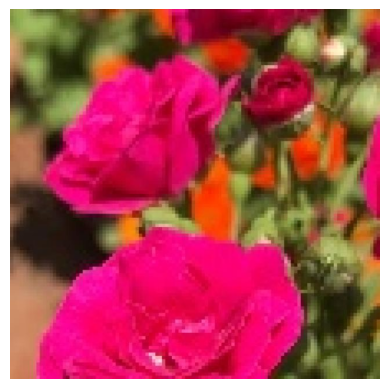

Predicted class for Rose119_jpg.rf.8dc9114d13b1b83d00722e9a58a402de.jpg: Rose (Score: 0.9676)


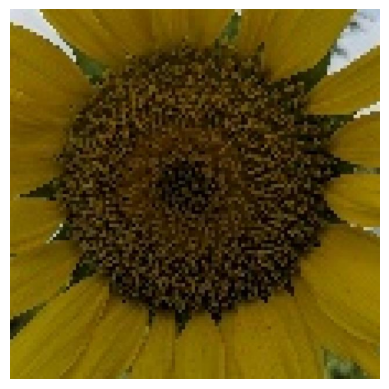

Predicted class for sunflower169_jpg.rf.ff08c32a2f36d8529390dfd17de415f7.jpg: sunflower (Score: 0.9997)


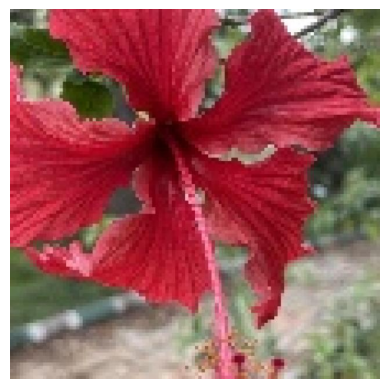

Predicted class for Hibiscus105_jpg.rf.26c931190c250225c582fdc938ce2d5d.jpg: Hibiscus (Score: 0.9975)


In [44]:
model.eval()
with torch.no_grad():
    for img_path in ['/content/drive/MyDrive/custom-flowers-dataset/valid/Rose/Rose119_jpg.rf.8dc9114d13b1b83d00722e9a58a402de.jpg', '/content/drive/MyDrive/custom-flowers-dataset/valid/sunflower/sunflower169_jpg.rf.ff08c32a2f36d8529390dfd17de415f7.jpg',"/content/drive/MyDrive/custom-flowers-dataset/valid/Hibiscus/Hibiscus105_jpg.rf.26c931190c250225c582fdc938ce2d5d.jpg"]:
        img = Image.open(img_path).convert('RGB')
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        img = transform(img).unsqueeze(0)
        img=img.to(device)
        output = model(img)
        _, predicted = torch.max(output.data, 1)
        predicted_class =class_names[predicted.item()]
        prediction_score = torch.softmax(output, dim=1)[0, predicted].item()

        print(f'Predicted class for {img_path.split("/")[-1]}: {predicted_class} (Score: {prediction_score:.4f})')